In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib

# Predição de mortalidade infantil baseado no dataset TWINS

O dataset original pode ser encontrado em ../data/original. Ele foi tratado no notebook de número 1 nessa mesma pasta, produzindo o dataset tratado em ../data/treated/. Além disso, foram feitas visualizações e computadas estatísticas no notebook de número 2.

In [14]:
data_path = pathlib.Path("../data/treated/twins_data.csv")
data_df = pd.read_csv(data_path)

Sumário:

- Tratamento dos dados para o treino
- Treinando os modelos
    - Dividindo os dados em treino e teste
    - Normalizando a coluna não categórica
    - Aplicando os modelos
        - Treinando os modelos
    - Análise dos resultados
        - Sobre os dados de teste
- Retreinando sobre dados melhor balanceados
    - Aplicando os modelos novamente
    - Nova análise dos resultados

## Tratamento dos dados para treino

In [15]:
data_df.head()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,...,dtotord_min,brstate_reg,stoccfipb_reg,mplbir_reg,lighter,first,id,weight,died,has_missing
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,31.0,...,1.0,5.0,5.0,1.0,1,0.0,1.0,2268.0,0.0,True
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,31.0,...,1.0,5.0,5.0,1.0,0,0.0,0.0,2296.0,0.0,True
2,1.0,1.0,1.0,1.0,3.0,0.0,2.0,3.0,0.0,1.0,...,3.0,5.0,5.0,5.0,1,0.0,7.0,2610.0,0.0,True
3,1.0,1.0,1.0,1.0,3.0,0.0,2.0,3.0,0.0,1.0,...,3.0,5.0,5.0,5.0,0,1.0,6.0,2650.0,0.0,True
4,1.0,1.0,1.0,1.0,5.0,0.0,1.0,5.0,1.0,59.0,...,1.0,5.0,5.0,1.0,1,0.0,11.0,1985.0,0.0,True


De acordo com o grafo causal, não precisaremos de algumas colunas:

In [16]:
unwanted_cols = [
    'id','birattnd', 'birmon', 'brstate', 'brstate_reg', 
    'crace', 'csex', 'data_year', 'dmar', 'feduc6', 'frace', 'meduc6',
    'mplbir', 'mplbir_reg', 'mrace', 'orfath', 'ormoth', 'pldel',
    'stoccfipb', 'stoccfipb_reg',
    'hemo', 'cardiac'
]

In [17]:
data_df.drop(unwanted_cols, inplace=True, axis=1)

In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142690 entries, 0 to 142689
Data columns (total 32 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mager8       142690 non-null  float64
 1   mpre5        142690 non-null  float64
 2   adequacy     142690 non-null  float64
 3   gestat10     142690 non-null  float64
 4   anemia       142690 non-null  float64
 5   lung         142690 non-null  float64
 6   diabetes     142690 non-null  float64
 7   herpes       142690 non-null  float64
 8   hydra        142690 non-null  float64
 9   chyper       142690 non-null  float64
 10  phyper       142690 non-null  float64
 11  eclamp       142690 non-null  float64
 12  incervix     142690 non-null  float64
 13  pre4000      142690 non-null  float64
 14  preterm      142690 non-null  float64
 15  renal        142690 non-null  float64
 16  rh           142690 non-null  float64
 17  uterine      142690 non-null  float64
 18  othermr      142690 non-

Todas as colunas estão marcadas como float64, entretanto, a grande maioria é categórica. Alterar o seu tipo para 'category' deve diminuir o consumo de memória de 56.6MB. Vamos ver quantos valores diferentes cada coluna tem:

In [19]:
values_per_col = dict()
for col in data_df.columns:
    values_per_col[col] = len(data_df[col].value_counts())

In [20]:
values_per_col

{'mager8': 8,
 'mpre5': 4,
 'adequacy': 3,
 'gestat10': 10,
 'anemia': 2,
 'lung': 2,
 'diabetes': 2,
 'herpes': 2,
 'hydra': 2,
 'chyper': 2,
 'phyper': 2,
 'eclamp': 2,
 'incervix': 2,
 'pre4000': 2,
 'preterm': 2,
 'renal': 2,
 'rh': 2,
 'uterine': 2,
 'othermr': 2,
 'tobacco': 2,
 'alcohol': 2,
 'cigar6': 6,
 'drink5': 5,
 'nprevistq': 5,
 'dfageq': 8,
 'dlivord_min': 16,
 'dtotord_min': 20,
 'lighter': 2,
 'first': 2,
 'weight': 3236,
 'died': 2,
 'has_missing': 2}

Algumas colunas são claramente categóricas. Vamos ver o que significa algumas dessas colunas.

In [21]:
cols_sig = {'adequacy': 'adequacy of care',
 'alcohol': 'risk factor, alcohol use',
 'anemia': 'risk factor, Anemia',
 'birattnd': 'medical person attending birth',
 'birmon': 'birth month Jan-Dec',
 'bord_0': 'birth order of lighter twin',
 'bord_1': 'birth order of heavier twin',
 'brstate': 'state of residence NCHS',
 'brstate_reg': 'US census region of brstate',
 'cardiac': 'risk factor, Cardiac',
 'chyper': 'risk factor, Hypertension, chronic',
 'cigar6': 'num of cigarettes /day, quantiled',
 'crace': 'race of child',
 'csex': 'sex of child',
 'data_year': 'year: 1989, 1990 or 1991',
 'dfageq': 'octile age of father',
 'diabetes': 'risk factor, Diabetes',
 'dlivord_min': 'number of live births before twins',
 'dmar': 'married',
 'drink5': 'num of drinks /week, quantiled',
 'dtotord_min': 'total number of births before twins',
 'eclamp': 'risk factor, Eclampsia',
 'feduc6': 'education category',
 'frace': 'dad race',
 'gestat10': 'gestation 10 categories',
 'hemo': 'risk factor Hemoglobinopathy',
 'herpes': 'risk factor, Herpes',
 'hydra': 'risk factor Hvdramnios/Oliqohvdramnios',
 'incervix': 'risk factor, Incompetent cervix',
 'infant_id_0': 'infant id of lighter twin in original df',
 'infant_id_1': 'infant id of heavier twin in original df',
 'lung': 'risk factor, Lung',
 'mager8': 'mom age',
 'meduc6': 'mom education',
 'mplbir': 'mom place of birth',
 'mplbir_reg': 'US census region of mplbir',
 'mpre5': 'trimester prenatal care begun, 4 is none',
 'mrace': 'mom race',
 'nprevistq': 'quintile number of prenatal visits',
 'orfath': 'dad hispanic',
 'ormoth': 'mom hispanic',
 'othermr': 'risk factor, Other Medical Risk Factors',
 'phyper': 'risk factor, Hypertension, preqnancy-associated',
 'pldel': 'place of delivery',
 'pre4000': 'risk factor, Previous infant 4000+ grams',
 'preterm': 'risk factor, Previos pre-term or small',
 'renal': 'risk factor, Renal disease',
 'rh': 'risk factor, RH sensitization',
 'stoccfipb': 'state of occurence FIPB',
 'stoccfipb_reg': 'US census region of stoccfipb',
 'tobacco': 'risk factor, tobacco use',
 'uterine': 'risk factor, Uterine bleeding'}

In [22]:
target_cols = [col for col, value in list(values_per_col.items()) if value > 6]
for col in target_cols:
    desc = cols_sig.get(col, '')
    print(f"{col}: {desc}")

mager8: mom age
gestat10: gestation 10 categories
dfageq: octile age of father
dlivord_min: number of live births before twins
dtotord_min: total number of births before twins
weight: 


Fica claro que o weight não é categórico. Poderia considerar a idade da mãe como não categórico, entretanto, vou dizer que é. 

In [23]:
def transform_to_categorical(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = df[col].astype('category')
    
    return df

NON_CAT_COL = ['weight']
CAT_COLS = data_df.columns.difference(NON_CAT_COL)
data_df = transform_to_categorical(data_df, CAT_COLS)

In [24]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142690 entries, 0 to 142689
Data columns (total 32 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   mager8       142690 non-null  category
 1   mpre5        142690 non-null  category
 2   adequacy     142690 non-null  category
 3   gestat10     142690 non-null  category
 4   anemia       142690 non-null  category
 5   lung         142690 non-null  category
 6   diabetes     142690 non-null  category
 7   herpes       142690 non-null  category
 8   hydra        142690 non-null  category
 9   chyper       142690 non-null  category
 10  phyper       142690 non-null  category
 11  eclamp       142690 non-null  category
 12  incervix     142690 non-null  category
 13  pre4000      142690 non-null  category
 14  preterm      142690 non-null  category
 15  renal        142690 non-null  category
 16  rh           142690 non-null  category
 17  uterine      142690 non-null  category
 18  othe

Agora ele só ocupa 5 MB.

# Treinando os modelos

## Dividindo os dados em treino e teste

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
y = data_df['died']
X = data_df.drop('died', axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Normalizando a coluna não categórica

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
def normalize(df, cols, scaler, already_fitted_scaler):
    numerical_only_data = df[cols]
    if not already_fitted_scaler:
        scaler.fit(numerical_only_data.values)
    
    numerical_scaled = scaler.transform(numerical_only_data.values)
    df.loc[:, cols] = numerical_scaled
    return df

Vou realizar o fit do Scaler com base nos dados de treino e aplica-lo também aos dados de teste.

In [30]:
scaler = MinMaxScaler()
NUM_COL = ['weight']
already_fitted_scaler = False
X_train = normalize(X_train, NUM_COL, scaler, already_fitted_scaler)

already_fitted_scaler = True
X_test = normalize(X_test, NUM_COL, scaler, already_fitted_scaler)

In [31]:
X_train['weight'].describe()

count    107017.000000
mean          0.331048
std           0.099795
min           0.000000
25%           0.280219
50%           0.344686
75%           0.396533
max           1.000000
Name: weight, dtype: float64

In [32]:
X_test['weight'].describe()

count    35673.000000
mean         0.330199
std          0.100795
min          0.000000
25%          0.277178
50%          0.342557
75%          0.396533
max          0.779383
Name: weight, dtype: float64

## Aplicando os modelos

Para realizar o treinamento, foram escolhidos os seguintes modelos:

- KNN
- HistGradientBoostingClassifier
- Rede Neural
- DecisionTrees

### Treinando os modelos

In [33]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [50]:
X.head()

,mager8,mpre5,adequacy,gestat10,anemia,lung,diabetes,herpes,hydra,chyper,...,cigar6,drink5,nprevistq,dfageq,dlivord_min,dtotord_min,lighter,first,weight,has_missing
0,3.0,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,1,0.0,2268.0,True
1,3.0,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,0,0.0,2296.0,True
2,3.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,2.0,3.0,1,0.0,2610.0,True
3,3.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,2.0,3.0,0,1.0,2650.0,True
4,5.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,6.0,1.0,1.0,1,0.0,1985.0,True


In [53]:
CATEGORICAL_COLS_MASK = [True]*29 + [False,True] 

In [54]:
DEFAULT_RANDOM_STATE = 42
#https://stackoverflow.com/a/61183983/16264901
knn_clf = KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree')
hist_clf = HistGradientBoostingClassifier(random_state=DEFAULT_RANDOM_STATE, l2_regularization=1,
                                        categorical_features=CATEGORICAL_COLS_MASK)
neural_clf = MLPClassifier(solver='adam', random_state=DEFAULT_RANDOM_STATE)
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=DEFAULT_RANDOM_STATE)

- Modelo KNN: Apesar de considerar a dimensionalidade como razoavelmente alta, gostaria de ver se um modelo de agrupamento simples conseguiria performar bem. Para tal, de acordo com a documentação o algoritmo 'ball-tree' deve performar melhor em quantidade de computações quando a dimensionalidade do dado é maior do que 20 comparado ao K-DTree.

- Modelo HistGradientBoostingClassifier: De acordo com a documentação, o sklearn possui essa nova implementação de gradient boosting trees para classificação. Esse modelo é inspirado no LightGBM e usa histogramas para dividir os dados. Além disso, na documentação é dito que ele poderia ser ordens de magnitude melhor do que o GradientBoosting caso a quantidade de dados seja maior do que dezenas de milhares, que é o caso atual.

- Modelo Neural: Defini o solver do modelo neural como 'adam', uma variação de stochastic gradient-based optimizer, pois, na documentação, está descrito como funcionar relativamente bem em datasets razoáveis, que, no caso, é de 119k entradas.

- Modelo RandomForest: O modeo RandomForest não possui nada fixo, os seus principais parâmetros serão variados no GridSearchCV

In [55]:
ensemble_clf=[knn_clf, hist_clf, neural_clf, forest_clf]

Vamos realizar um GridSearch com validação cruzada de 5 folds.

In [56]:
len(X_train.columns)

31

In [57]:
hist_params={"learning_rate":[0.001,0.01,0.1], "max_iter":range(100,1000,200), 'max_depth':range(1, 20, 4)}
knn_params = {"n_neighbors": [5, 9, 13, 18], "metric":['euclidean']}
neural_params = {"hidden_layer_sizes":[(31), (31, 20), (31, 20, 10), (31, 20, 10, 5)], "max_iter":[25000]}
forest_params = {'n_estimators':[30, 50, 70, 100], 'min_samples_split':[2, 4, 8, 16], 'criterion':['entropy']}

- HistGradientBoostingClassifier: Por ser um modelo de boosting, os decision stumps do modelo podem/devem ser de baixíssima capacidade. Por padrão, o sklearn não define a profundidade máxima das árvores, portanto, variei esse valor entre 1 e 20. Além disso, variei a quantidade máxima de decision stumps até 1000 pois os modelos de boosting são bem robustos. Também variei o learning_rate.

- KNN: As principais questões do modelo KNN é como computar a distância dos pontos e a quantidade de vizinhos a serem levados em consideração. Dessa forma, defini a métrica de distância como a distância euclidiana e variei a quantidade de vizinhos até 13. Um valor baixo de vizinhos (5) supõe que as classes de dados sejam bem definidas e um valor mais alto (18) supõe que eles estejam mais misturados/sejam ruidosos.

- Neural: Considerando que são 31 features de entrada, resolvi testar quatro configurações diferentes, sendo eles:

    - 1 camada oculta: Possui uma camada oculta com 31 nós.
    - 2 camadas ocultas: A primeira camada oculta com 31 nós e a segunda com 20 nós
    - 3 camadas ocultas: A primeira camada oculta com 31 nós, a segunda com 20 e a terceira com 10
    - 4 camadas ocultas: A primeira camada oculta com 31 nós, a segunda com 20, a terceira com 10 e a quarta com 5
    
Por padrão, o early-stopping já é definido como False, mas, apesar disso, o treinamento é interrompido se o modelo não melhorar por 0.0001 durante 10 iterações. Considerando que temos 119k entradas com 5 folds, considerei que um número de iterações máximo de 25 mil talvez já fosse suficiente para o modelo convergir.

- RandomForest: Os principais parâmetros do RandomForest é a quantidade de árvores utilizadas e a quantidade mínima de entradas para se tentar dividir os dados. Dessa forma, variei esses parâmetros arbitrariamente.

In [58]:
parameters_list=[knn_params, hist_params, neural_params, forest_params]

**ATENÇÃO**: Se quiser executar, de fato, os modelos, defina a variável JUST_LOAD_DATA como False. Se quiser apenas carregar os melhores modelos encontrados, defina JUST_LOAD_DATA como True.

In [91]:
JUST_LOAD_DATA = True

models = ['knn', "hist_boosting", 'neuralNet', 'forest']

best_models = []
best_scores = []
best_params = []
all_params = {}
mean_test_scores = {}
best_index = {}

import pathlib
    
target_models_dir = pathlib.Path("../models/after_causal_graph")
target_models_dir.mkdir(exist_ok=True, parents=True)

if JUST_LOAD_DATA:
    from joblib import load
    for model in models:
        grid = load(target_models_dir / f"grid_{model}.joblib")
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[model] = grid.cv_results_['params']
        mean_test_scores[model] = grid.cv_results_['mean_test_score']
        best_index[model] = grid.best_index_
else:
    from sklearn.model_selection import GridSearchCV
    from joblib import dump

    for i in range(len(ensemble_clf)):
        print(f"Começando treino de {ensemble_clf[i]}")
        grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                          n_jobs=-1, cv=5, verbose=3, scoring='accuracy').fit(X_train, y_train)
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[models[i]] = grid.cv_results_['params']
        mean_test_scores[models[i]] = grid.cv_results_['mean_test_score']
        best_index[models[i]] = grid.best_index_
        dump(grid.best_estimator_,target_models_dir / f"best_{models[i]}.joblib")
        dump(grid, target_models_dir / f"grid_{models[i]}.joblib")

## Análise dos Resultados

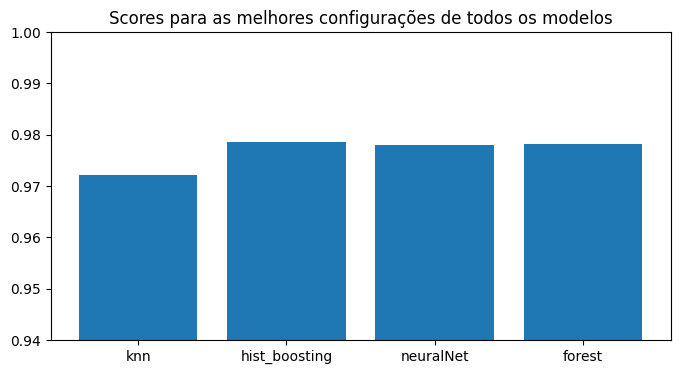

In [66]:
plt.figure(figsize=(8,4))
plt.bar(models, best_scores)
plt.title("Scores para as melhores configurações de todos os modelos")
plt.ylim((0.94, 1))
plt.show()

In [67]:
for model, score in zip(models, best_scores):
    print(f"Score do {model}: {score}")

Score do knn: 0.9721165788957169
Score do hist_boosting: 0.9785735137233864
Score do neuralNet: 0.9780502365664239
Score do forest: 0.9782184281178417


De acordo com os resultados, o modelo que melhor performou foi o HistGradientBoostingClassifier. Sua melhor configuração obteve um score médio de 0.9885 na validação cruzada.

A melhor configuração do HistGradientBoostingClassifier foi:

In [70]:
best_params[1]

{'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100}

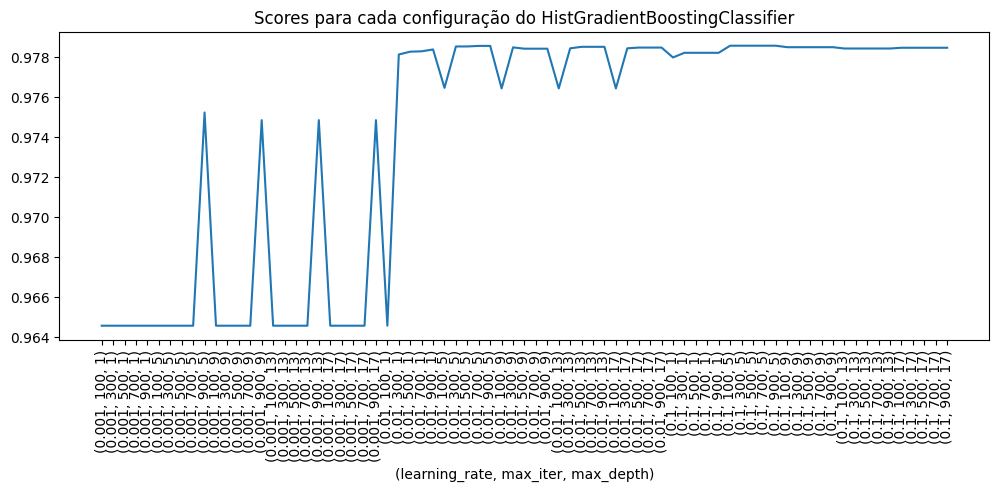

In [92]:
params_axis = [f"({param['learning_rate']}, {param['max_iter']}, {param['max_depth']})" for param in all_params[models[1]]]
plt.figure(figsize=(12,4))
plt.plot(params_axis, mean_test_scores[models[1]])
plt.title("Scores para cada configuração do HistGradientBoostingClassifier")
plt.xlabel("(learning_rate, max_iter, max_depth)")
plt.xticks(rotation=90)
plt.show()

### Sobre os dados de teste

In [73]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

def plotBestEstimatorResults(estimator, X_test, y_test, model_name):
    y_pred = estimator.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    
    plotConfusionMatrix(y_test, y_pred, model_name)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plotROC(fpr, tpr, model_name)
    
    plotPrecisionRecall(estimator, y_test , y_pred, model_name)
    
def plotConfusionMatrix(y_test, y_pred, model=None):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    """
    # cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    plt.show()

def plotROC(fpr, tpr, model_name):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    plt.figure(figsize=(8,6))
    lw = 2
    aucArea = auc(fpr,tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % aucArea,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

def plotPrecisionRecall(estimator, y_true, y_pred, modelName):
    display = PrecisionRecallDisplay.from_predictions(
        y_true, y_pred, name=modelName
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    plt.legend(loc='lower left')
    plt.show()

              precision    recall  f1-score   support

         0.0      0.981     0.995     0.988     34343
         1.0      0.795     0.506     0.618      1330

    accuracy                          0.977     35673
   macro avg      0.888     0.750     0.803     35673
weighted avg      0.974     0.977     0.974     35673



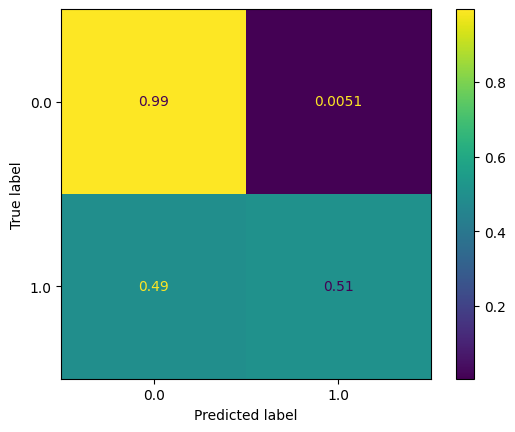

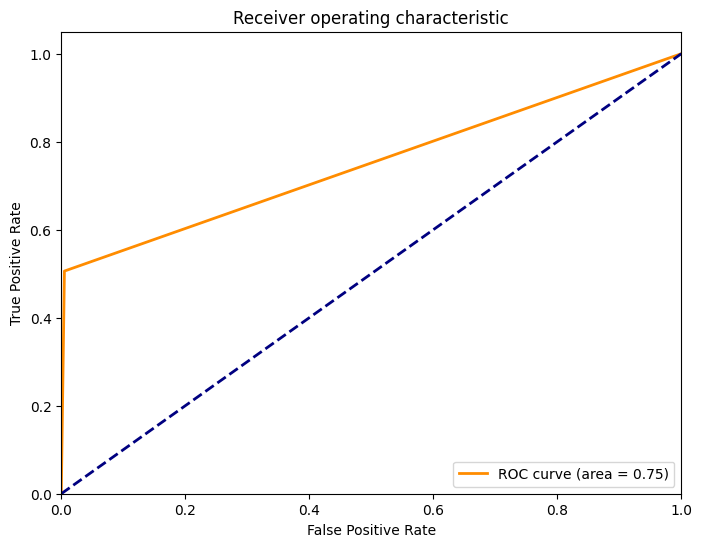

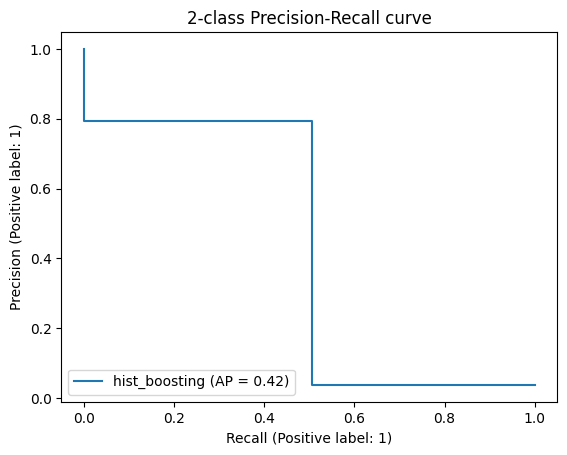

In [74]:
plotBestEstimatorResults(best_models[1], X_test, y_test, models[1])

Aconteceu o que eu temia, a grande diferença de proporção de dados died=0 e died=1 afetou o treinamento dos modelos. Ao praticamente prever sempre que a criança não morrerá, já que existem muito mais crianças que não morreram, os modelos aumentam a sua acurácia.

Vou tentar refazer os passos de treino mas com dados de treino melhor balanceados, com cerca de 60% dos dados como não morreram e 40% como morreram. Para tal, acreditarei que esses 60% que não morreram serão representativos o suficiente daqueles que não morreram para, ainda assim, manter os bons indicadores para essa classe nos resultados dos modelos.

## Retreinando com dados melhor balanceados

Vamos ver a distribuição das categorias dos dados de treino e teste:

In [75]:
y_train.value_counts()

0.0    103223
1.0      3794
Name: died, dtype: int64

In [76]:
y_test.value_counts()

0.0    34343
1.0     1330
Name: died, dtype: int64

Existem 3794 instâncias onde os bebês morreram. Se isso for 40% dos dados, então isso significa que os outros 60% são 5691. Assim, vou modificar X_train para ter essa proporção e o resto irá para os dados de teste.

In [77]:
#Pegando só o que interessa para o treino

#Todos os que já eram died == 1
new_y_train = y_train[y_train == 1]
#Mais só 5691 dos que died == 0
new_y_train = pd.concat([new_y_train, y_train[y_train == 0].iloc[:5691]])

#O mesmo para o X
new_X_train = X_train[y_train == 1]
new_X_train = pd.concat([new_X_train, X_train[y_train == 0].iloc[:5691]])

#Movendo os não utilizados do treino antigo para o teste novo

#O novo y_test é o mesmo que o anterior acrescido dos died == 0 não utilizados no novo treino
new_y_test = y_test.copy()
new_y_test = pd.concat([new_y_test, y_train[y_train == 0].iloc[5691:]])

#O mesmo para o x_test
new_X_test = X_test.copy()
new_X_test = pd.concat([new_X_test, X_train[y_train == 0].iloc[5691:]])

In [78]:
new_y_train.value_counts()

0.0    5691
1.0    3794
Name: died, dtype: int64

In [79]:
new_y_test.value_counts()

0.0    131875
1.0      1330
Name: died, dtype: int64

## Aplicando os mesmos modelos novamente

Mas sobre o new_X_train e new_y_train

In [93]:
JUST_LOAD_DATA = True

models = ['knn', "hist_boosting", 'neuralNet', 'forest']

best_models = []
best_scores = []
best_params = []
all_params = {}
mean_test_scores = {}
best_index = {}

import pathlib
    
target_models_dir = pathlib.Path("../models/after_causal_graph_balanced")
target_models_dir.mkdir(exist_ok=True, parents=True)

if JUST_LOAD_DATA:
    from joblib import load
    for model in models:
        grid = load(target_models_dir / f"grid_{model}.joblib")
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[model] = grid.cv_results_['params']
        mean_test_scores[model] = grid.cv_results_['mean_test_score']
        best_index[model] = grid.best_index_
else:
    from sklearn.model_selection import GridSearchCV
    from joblib import dump

    for i in range(len(ensemble_clf)):
        print(f"Começando treino de {ensemble_clf[i]}")
        grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                          n_jobs=-1, cv=5, verbose=3, scoring='accuracy').fit(new_X_train, new_y_train)
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[models[i]] = grid.cv_results_['params']
        mean_test_scores[models[i]] = grid.cv_results_['mean_test_score']
        best_index[models[i]] = grid.best_index_
        dump(grid.best_estimator_,target_models_dir / f"best_{models[i]}.joblib")
        dump(grid, target_models_dir / f"grid_{models[i]}.joblib")

### Nova análise dos resultados

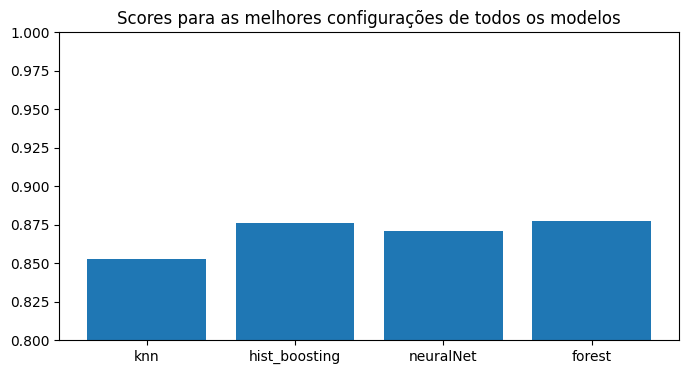

In [94]:
plt.figure(figsize=(8,4))
plt.bar(models, best_scores)
plt.title("Scores para as melhores configurações de todos os modelos")
plt.ylim((0.8, 1))
plt.show()

In [95]:
for model, score in zip(models, best_scores):
    print(f"Score do {model}: {score}")

Score do knn: 0.8523985239852399
Score do hist_boosting: 0.8762256193990512
Score do neuralNet: 0.8710595677385345
Score do forest: 0.8772799156562995


De acordo com os resultados, o modelo que melhor performou foi o RandomForest. Sua melhor configuração obteve um score médio de 0.877 na validação cruzada.

A melhor configuração do RandomForest foi:

In [96]:
best_params[3]

{'criterion': 'entropy', 'min_samples_split': 16, 'n_estimators': 70}

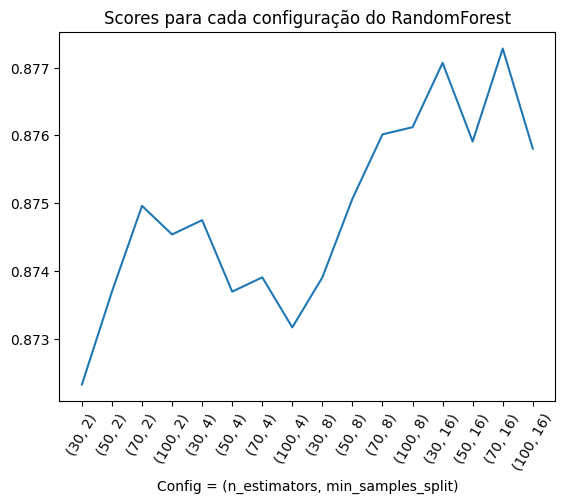

In [97]:
params_axis = [f"({param['n_estimators']}, {param['min_samples_split']})" for param in all_params[models[3]]]
plt.plot(params_axis, mean_test_scores[models[3]])
plt.xticks(rotation=60)
plt.title("Scores para cada configuração do RandomForest")

plt.xlabel("Config = (n_estimators, min_samples_split)")
plt.show()

### Sobre os dados de teste

              precision    recall  f1-score   support

         0.0      0.998     0.947     0.972    131875
         1.0      0.129     0.778     0.222      1330

    accuracy                          0.945    133205
   macro avg      0.563     0.863     0.597    133205
weighted avg      0.989     0.945     0.964    133205



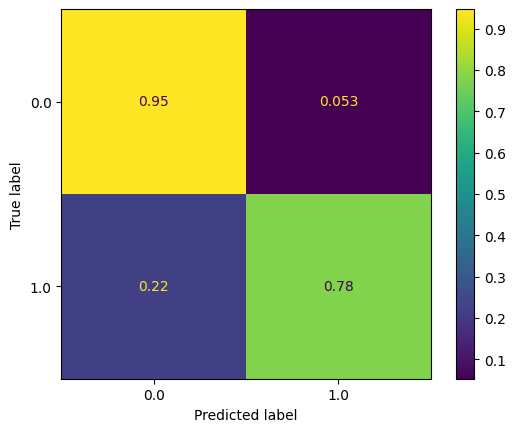

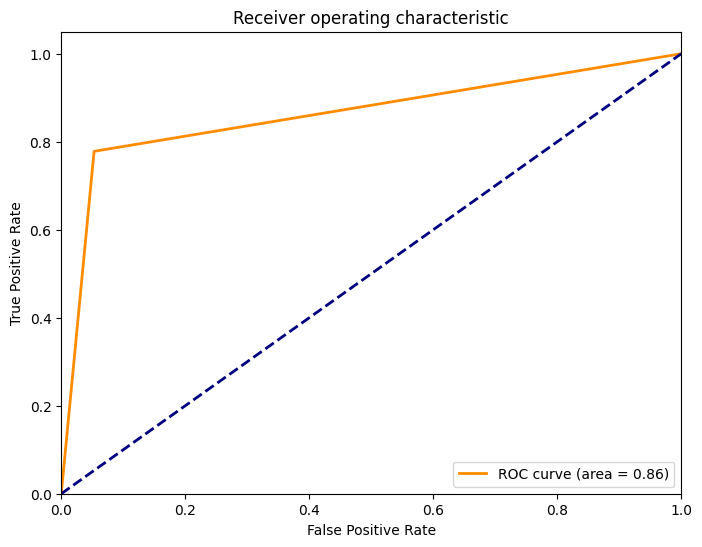

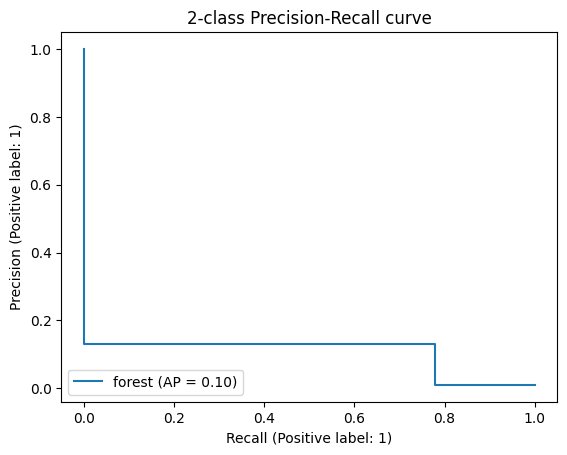

In [98]:
plotBestEstimatorResults(best_models[3], new_X_test, new_y_test, models[3])

Dessa vez, a proporção dos bebês que morreram e que foram corretamente identificados subiu para 78% sobre o custo de perder um pouco de precisão para o caso de died == 0. Dessa forma, o modelo vencedor é aquele em: ../models/after_causal_graph_balanced/best_forest.joblib